/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM


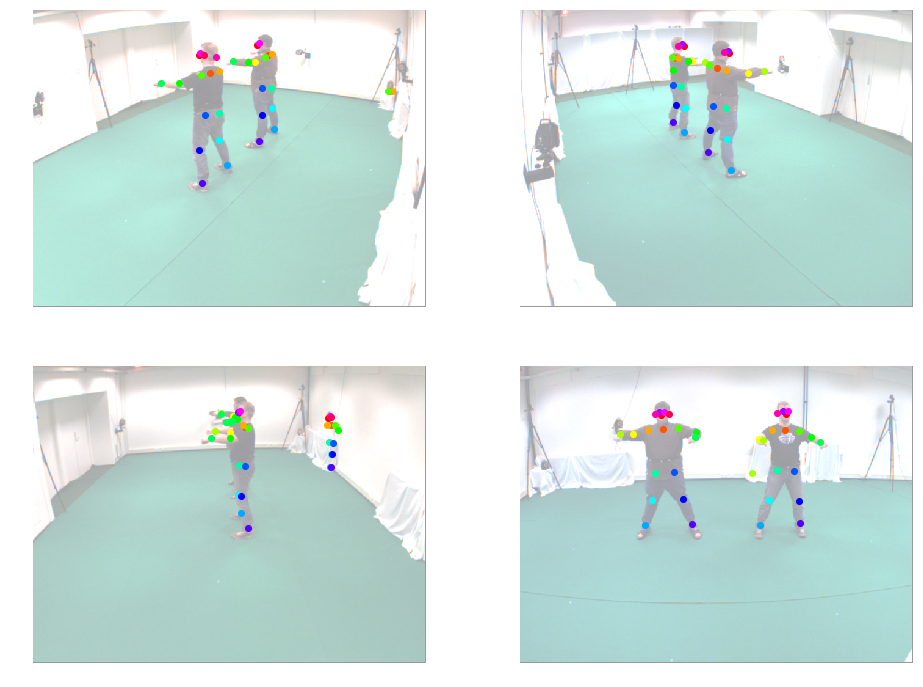

In [26]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import isfile
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.insert(0,'../../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../../')
import mvpose.data.transform as tfm
import mvpose.geometry.geometry as gm
from mvpose.geometry import stereo
import mvpose.pose_estimation.heatmaps as mvhm
from mvpose.candidates import peaks as mvpeaks
import mvpose.pose_estimation.part_affinity_fields as mvpafs
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_MAP_IDX
from mvpose.algorithm import graphcut
from cselect import color as cs




root = join(Settings['data_root'], 'pak')

from poseestimation import model
pe = model.PoseEstimator()


from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)

# interesting frames: [340, 215, 250]
FRAME = 0

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])
with_gpu = False

if with_gpu:
    _start = time()
    heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
    _end = time(); print('elapsed:', _end - _start)
else:
    hm_file = '/tmp/heatmaps' + str(FRAME) + '.npy'
    paf_file = '/tmp/pafs' + str(FRAME) + '.npy'
    
    if isfile(hm_file) and isfile(paf_file):
        heatmaps = np.load(hm_file)
        pafs = np.load(paf_file)
    else:
        heatmaps = []; pafs = []
        for im in Im:
            _start = time()
            hm, paf = pe.predict_pafs_and_heatmaps(im)
            heatmaps.append(np.squeeze(hm))
            pafs.append(np.squeeze(paf))
            _end = time()
            print('elapsed:', _end - _start)
        heatmaps = np.array(heatmaps)
        pafs = np.array(pafs)
        np.save(hm_file, heatmaps)
        np.save(paf_file, pafs)
        
import mvpose.plot.limbs as pltlimbs

colors = cs.lincolor(19)/255

r = 200
Gr = graphcut.GraphCutSolver(heatmaps, pafs, Calib, r)

fig = plt.figure(figsize=(16,12))

for idx, im in enumerate(Im):
    ax = fig.add_subplot(2,2,idx+1)
    ax.imshow(im, alpha=0.4)
    ax.axis('off')
    
    for jid in range(Gr.peaks2d[idx].n_joints):
        for x,y,score in Gr.peaks2d[idx][jid]:
            ax.scatter(x,y, color=colors[jid])
    
plt.show()

## Undistored peaks

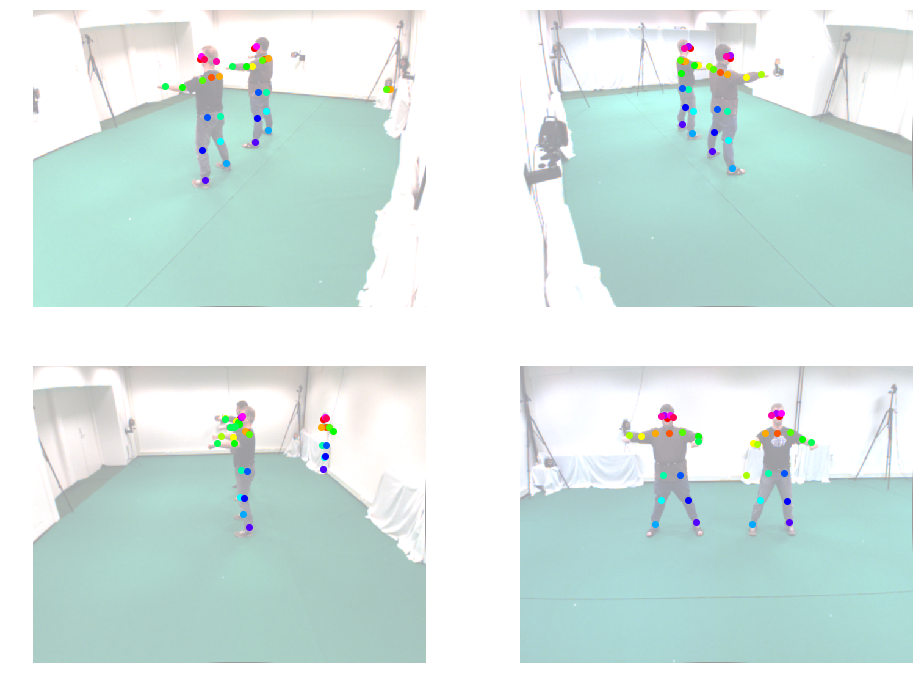

In [27]:
fig = plt.figure(figsize=(16,12))

for idx, im in enumerate(Im):
    ax = fig.add_subplot(2,2,idx+1)
    
    mapx, mapy = Gr.undistort_maps[idx]
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    
    ax.imshow(im, alpha=0.4)
    ax.axis('off')
    
    for jid in range(Gr.peaks2d_undistorted[idx].n_joints):
        for x,y,score in Gr.peaks2d_undistorted[idx][jid]:
            ax.scatter(x,y, color=colors[jid])
            
plt.show()

## Re-distort 
This is needed for mapping the 3d points onto the part affinity fields

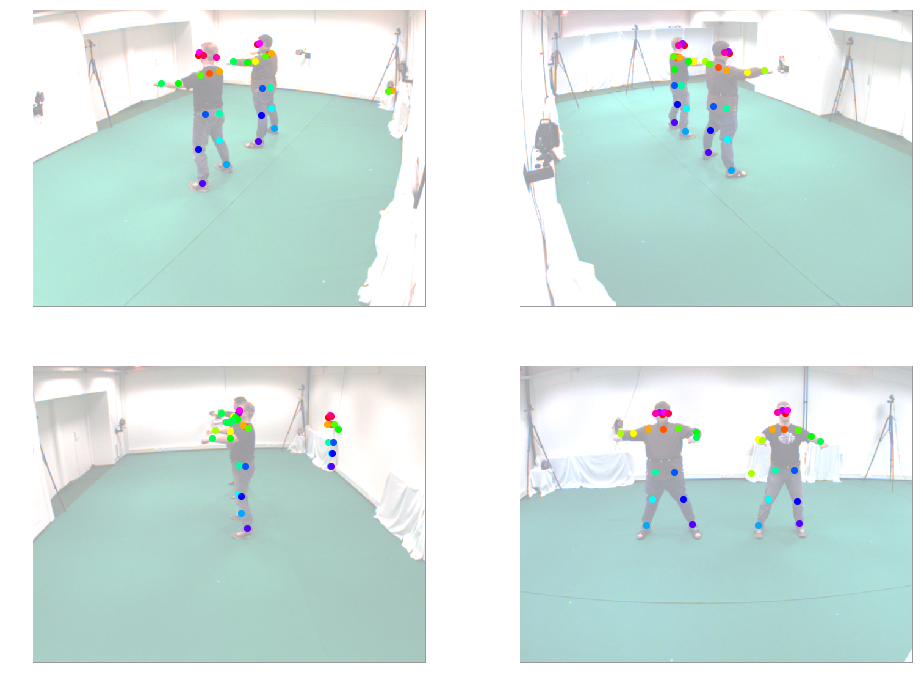

In [28]:
fig = plt.figure(figsize=(16,12))

for idx, im in enumerate(Im):
    ax = fig.add_subplot(2,2,idx+1)
    
    mapx, mapy = Gr.undistort_maps[idx]
    
    ax.imshow(im, alpha=0.4)
    ax.axis('off')
    
    for jid in range(Gr.peaks2d_undistorted[idx].n_joints):
        points = Gr.peaks2d_undistorted[idx][jid]
        points_dist = gm.distort_points(points, mapx, mapy)
        for x,y,score in points_dist:
            ax.scatter(x,y, color=colors[jid])
            
plt.show()

## Show all 3d peaks with weights

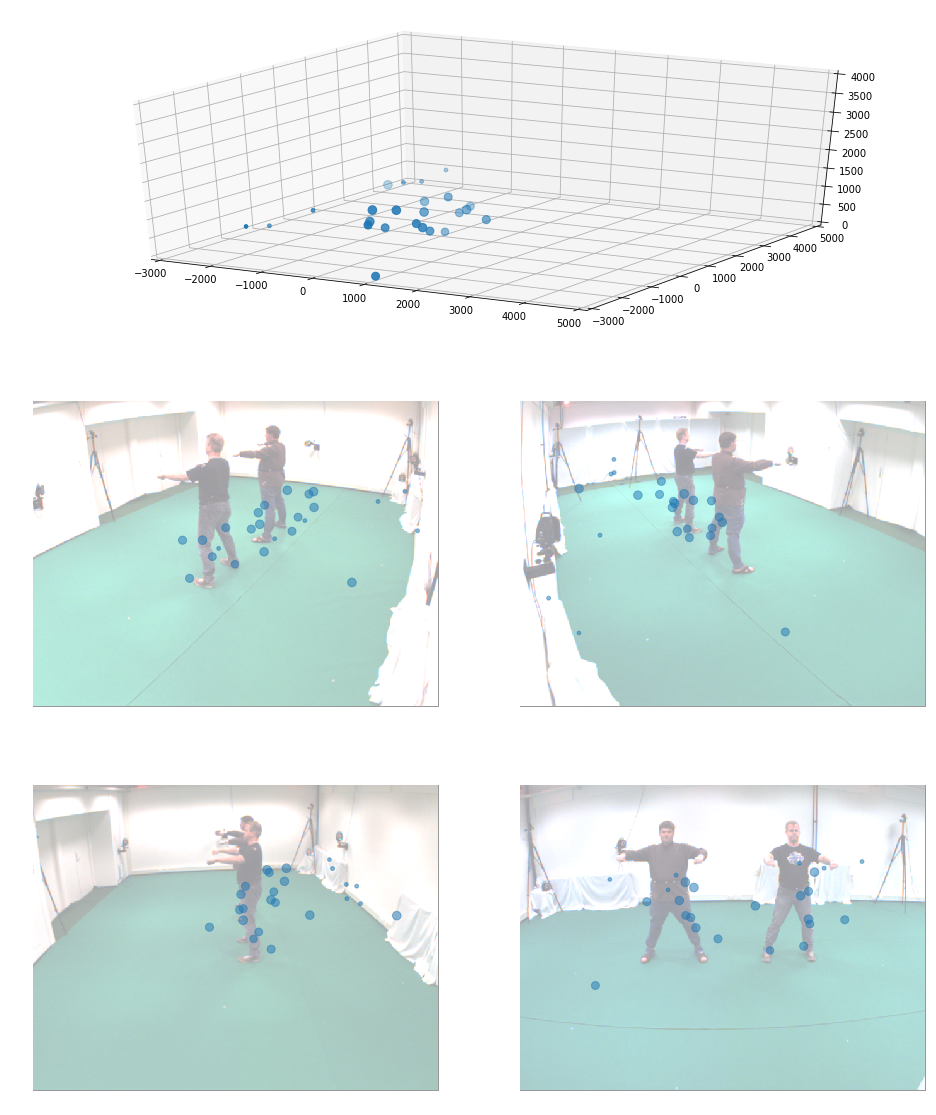

In [29]:
JOINT_ID = 12
Noses = Gr.peaks3d_weighted[JOINT_ID]

fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(311, projection='3d')
ax.set_xlim([-3000, 5000])
ax.set_ylim([-3000, 5000])
ax.set_zlim([0, 4000])

X = Noses[:,0]
Y = Noses[:,1]
Z = Noses[:,2]
W = Noses[:,3] * Noses[:,4]

ax.scatter(X,Y,Z, s=W*100)

# --- reproject ---
Pts3d = Noses[:,0:3]
Pts3d = Pts3d.astype('float64')

for idx, cam in enumerate(Gr.Calib_undistorted):
    ax = fig.add_subplot(3,2,3+idx)
    ax.axis('off')
    
    im = Im[idx]
    
    ax.imshow(im, alpha=0.4)
    
    Noses2d = Gr.candidates2d[idx][JOINT_ID]
    #Noses2d = Gr.candidates2d_undistorted[idx][0]
    
    x = Noses2d[:,0]
    y = Noses2d[:,1]
    W = Noses2d[:,2] *  Noses2d[:,3]
    ax.scatter(x,y, alpha=0.5, s=W*100)
    
    
plt.show()

elapsed 0.1996140480041504


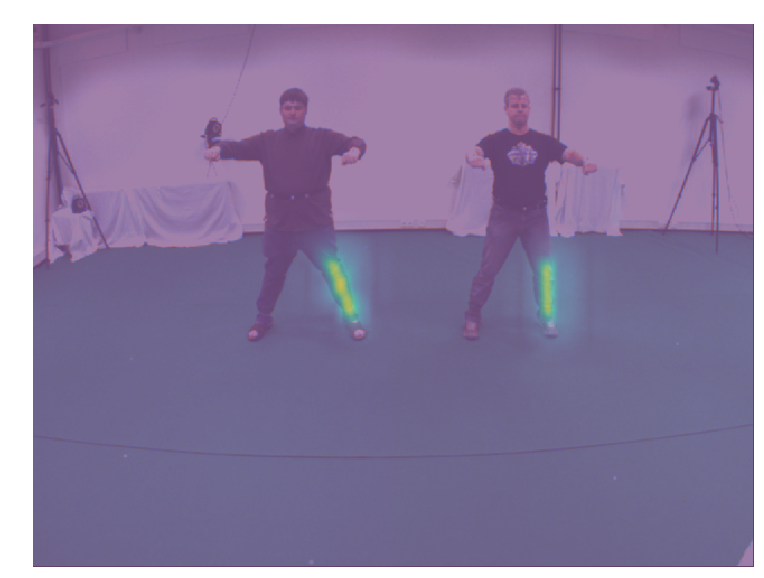

In [30]:
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH, DEFAULT_MAP_IDX
from mvpose.plot.limbs import draw_vector_field

assert len(DEFAULT_MAP_IDX) == len(DEFAULT_LIMB_SEQ)

LIMB_ID = 11
a,b = DEFAULT_MAP_IDX[LIMB_ID]

U = pafs[3,:,:,a]
V = pafs[3,:,:,b]

_start = time()
Vec = draw_vector_field(U, V)
_end = time()
print('elapsed', _end - _start)

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.imshow(Im[3], alpha=0.5)
ax.matshow(Vec, alpha=0.5)
ax.axis('off')
plt.show()

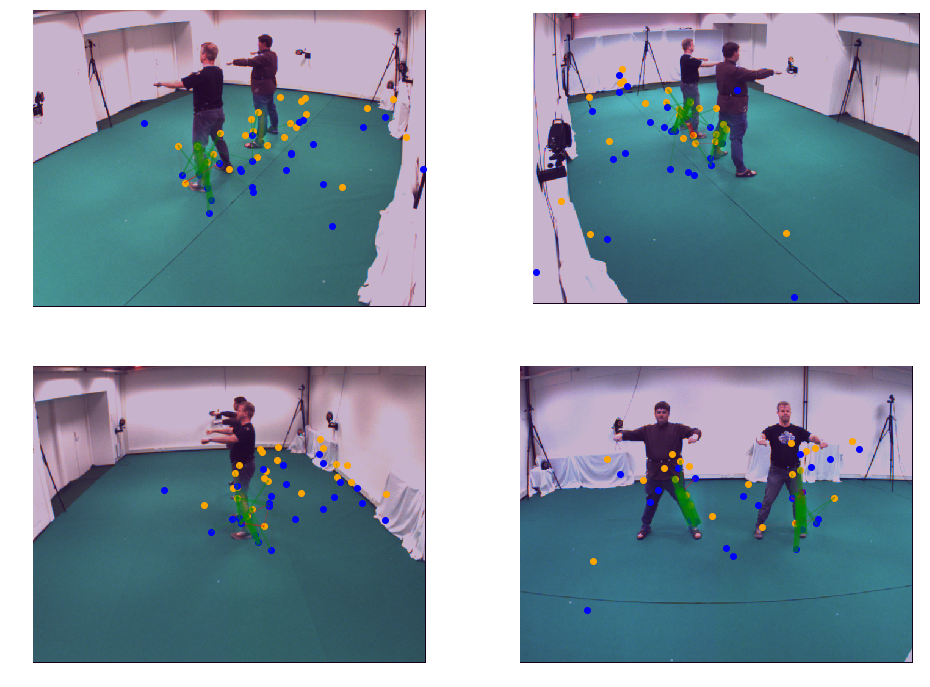

In [31]:
import numpy.linalg as la

cid = 2
LIMB_ID = 11

#cam = Calib[cid]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = plt.figure(figsize=(16,12))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

a,b = DEFAULT_LIMB_SEQ[LIMB_ID]
pafA, pafB = DEFAULT_MAP_IDX[LIMB_ID]
length_min, length_max = DEFAULT_SENSIBLE_LIMB_LENGTH[LIMB_ID]

candA3d = Gr.peaks3d_weighted[a]
candB3d = Gr.peaks3d_weighted[b]
nA = len(candA3d)
nB = len(candB3d)

W = np.zeros((nA, nB))

for cid, cam in enumerate(Calib):
    im = Im[cid]
    ax = fig.add_subplot(2,2,cid+1)
    ax.imshow(im)
    ax.axis('off')
    
    
    K, rvec, tvec, distCoef = gm.get_camera_parameters(cam)
    U = pafs[cid,:,:,pafA]
    V = pafs[cid,:,:,pafB]

    h,w,_ = im.shape

    ptsA2d, maskA = gm.reproject_points_to_2d(
        candA3d[:,0:3], rvec, tvec, K, w, h, distCoef=distCoef, binary_mask=True)
    ptsB2d, maskB = gm.reproject_points_to_2d(
        candB3d[:,0:3], rvec, tvec, K, w, h, distCoef=distCoef, binary_mask=True)


    maskA = maskA == 1
    maskB = maskB == 1

    for i, (ptA, ptA3d, is_A_on_screen) in enumerate(zip(ptsA2d, candA3d, maskA)):
        if is_A_on_screen:
            ax.scatter(ptA[0], ptA[1], color='orange')

    for j, (ptB, ptB3d, is_B_on_screen) in enumerate(zip(ptsB2d, candB3d, maskB)):
        if is_B_on_screen:
            ax.scatter(ptB[0], ptB[1], color='blue')

    Vec = draw_vector_field(U, V)
    ax.imshow(Vec, alpha=0.3)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    for i, (ptA, ptA3d, is_A_on_screen) in enumerate(zip(ptsA2d, candA3d, maskA)):
        if not is_A_on_screen:
            continue
        ptA = np.expand_dims(ptA, axis=0)
        for j, (ptB, ptB3d, is_B_on_screen) in enumerate(zip(ptsB2d, candB3d, maskB)):
            if not is_B_on_screen:
                continue
            distance = la.norm(ptA3d[0:3] - ptB3d[0:3])
            if length_min < distance < length_max:
                ptB = np.expand_dims(ptB, axis=0)

                line_int = mvpafs.calculate_line_integral(ptA, ptB, U, V)
                w = np.squeeze(line_int)
                W[i,j] += w
                Ax, Ay = np.squeeze(ptA)
                Bx, By = np.squeeze(ptB)

                if w > 0:
                    ax.plot([Ax, Bx], [Ay, By], color='green', linewidth=w, alpha=0.4)
                else:
                    ax.plot([Ax, Bx], [Ay, By], color='red', linewidth=-w, alpha=0.4)
            
plt.show()

## Build graph using pafs

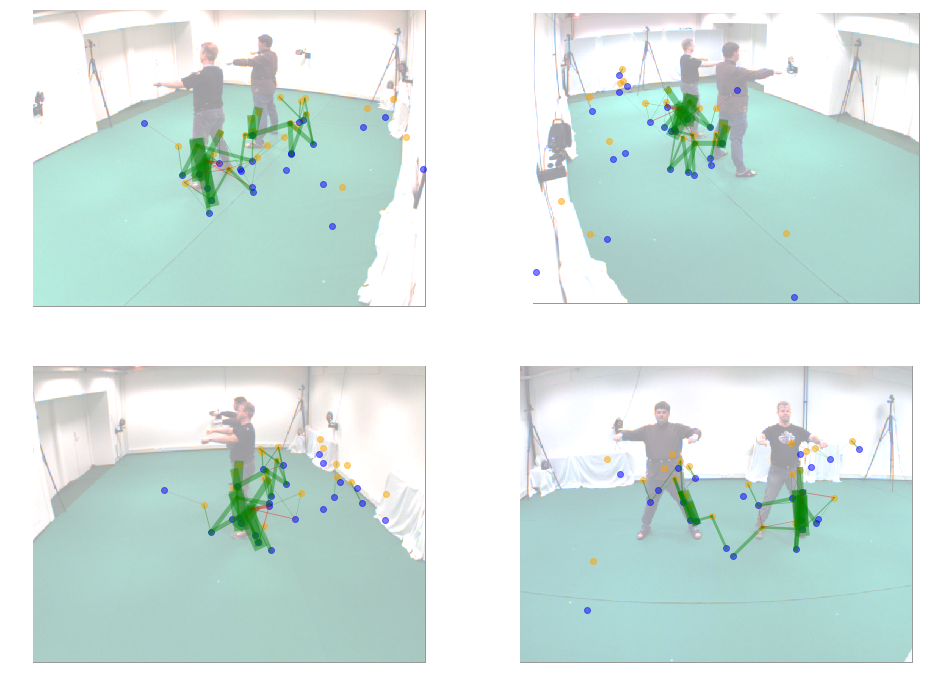

In [32]:
# take some random limb (left elbow -> hand left)
LIMB_ID = 11
a,b = DEFAULT_LIMB_SEQ[LIMB_ID]

W = Gr.limbs3d[LIMB_ID]
n,m = W.shape
candA = Gr.peaks3d_weighted[a][:,0:3]
candB = Gr.peaks3d_weighted[b][:,0:3]
assert n == len(candA) and m == len(candB)

fig = plt.figure(figsize=(16,12))

#for idx, cam in enumerate(Gr.Calib_undistorted):
for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    K, rvec, tvec, distCoef = gm.get_camera_parameters(cam)
    
    ptsA2d, maskA = gm.reproject_points_to_2d(candA, rvec, tvec, K, w, h, distCoef=distCoef)
    ptsB2d, maskB = gm.reproject_points_to_2d(candB, rvec, tvec, K, w, h, distCoef=distCoef)
    
    ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='orange', alpha=0.5)
    ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='blue', alpha=0.5)
    
    for _a in maskA[0]:
        for _b in maskB[0]:
            w = W[_a,_b]
            Ax,Ay = ptsA2d[_a]
            Bx,By = ptsB2d[_b]
            if w > 0:
                ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w/2, alpha=0.4)
            else:
                ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w/2, alpha=0.4)


plt.show()

## Solve the optimization problem

$$
E = \biggr(\sum_{j_1}^{J_1} \sum_{j_2}^{J_2} \lambda(j_1, j_2) \Phi(j_1, j_2) \biggr)
+ \biggr(\sum_{j_1}^{J_1} \sum_{j_2}^{J_1} \iota(j_1, j_2)\Pi(j_1, j_2) \biggr)
+ \biggr(\sum_{j_1}^{J_2} \sum_{j_2}^{J_2} \iota(j_1, j_2)\Pi(j_1, j_2) \biggr)
$$

given the following transitivity conditions:

$$\lambda(a,c) + \lambda(b,c) - 1 \leq \iota(a,b)$$
$$\lambda(a,c) + \iota(a,b) - 1 \leq \lambda(b,c)$$

In [25]:
# small test run
#
#   [0] [1]     [2] [3]
#
#   (0) (1)     (2) (3)
#
#     {0}         {1}
import numpy as np
from ortools.linear_solver import pywraplp


L1 = np.array([
    [5, 5, 0, 0.5],
    [5, 6, -1, -5],
    [-1,0, 1, 5],
    [-5,0, 5, 3]
])

L2 = np.array([
    [5, -2],
    [5, 1],
    [0, 3],
    [-9, 10]
])


# J1, J2, J3 symmetric
J1 = np.array([
    [0, 5, -1, 1],
    [5, 0, 0, 0],
    [-1, 0, 0, 5],
    [1, 0, 5, 0]
])

J2 = np.array([
    [0, 5, -1, 1],
    [5, 0, 0, 0],
    [-1, 0, 0, 5],
    [1, 0, 5, 0]
])

J3 = np.array([
    [0, -9],
    [-1, 5]
])


# ----------------

solver = pywraplp.Solver('SolveAssignmentProblemMIP',
                               pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

LM = []
IO = {}

_J_ = [J1, J2, J3]
Limbs = [(0, 1), (1,2)]

Sums = []


for idx, (L, (a, b)) in enumerate(zip([L1, L2], Limbs)):
    n,m = L.shape
    lm = {}
    for i in range(n):
        for j in range(m):
            lm[i,j] = solver.BoolVar('lambda%i[%i,%i]' % (idx,i,j))
    LM.append(lm)
    
    is_a_set = a in IO
    if not is_a_set:
        io1 = {}
        for i in range(n):
            for j in range(n):
                io1[i,j] = solver.BoolVar('iota%i[%i,%i]' % (a,i,j))
        IO[a] = io1
    else:
        io1 = IO[a]
    
    is_b_set = b in IO
    if not is_b_set:
        io2 = {}
        for i in range(m):
            for j in range(m):
                io2[i,j] = solver.BoolVar('iota%i[%i,%i]' % (b,i,j))
        IO[b] = io2
    else:
        io2 = IO[b]
        
    for a in range(n):
        for b in range(n):
            for c in range(m):
                solver.Add(lm[a,c] + lm[b,c] -1 <= io1[a,b])
                solver.Add(lm[a,c] + io1[a,b] - 1 <= lm[b,c])
                

    for a in range(m):
        for b in range(m):
            for c in range(n):
                solver.Add(lm[c,a] + lm[c,b] -1 <= io2[a,b])
                solver.Add(lm[c,a] + io2[a,b] - 1 <= lm[c,b])
    
    sum1 = solver.Sum(
        lm[a,b] * L[a,b] for a in range(n) for b in range(m))
    Sums.append(sum1)
    
    if not is_a_set:
        sum2 = solver.Sum(
            io1[a,b] * J1[a,b] for a in range(n) for b in range(n))
        Sums.append(sum2)
    
    if not is_b_set:
        sum3 = solver.Sum(
            io2[a,b] * J2[a,b] for a in range(m) for b in range(m))
        Sums.append(sum3)

solver.Maximize(sum(Sums))
solver.Solve()
print("Time = ", solver.WallTime(), " ms")

# {a0 a1 b0 b1 c0}, {a2 a3 b2 b3 c1}

# L1_graph = []
# L2_graph = []
# J1_graph = []
# J2_graph = []
# J3_graph = []

L_graph = []
J_graph = {}


for idx, (L, (a, b)) in enumerate(zip([L1, L2], Limbs)):
    n,m = L.shape
    lm = LM[idx]
    io1 = IO[a]
    io2 = IO[b]
    
    l_graph = []
    for a in range(n):
        for b in range(m):
            if lm[a,b].solution_value() > 0:
                l_graph.append((a,b))
    L_graph.append(l_graph)
    
    j1_graph = []
    if not a in J_graph:
        for a in range(n):
            for b in range(n):
                if io1[a,b].solution_value() > 0:
                    j1_graph.append((a,b))
        J_graph[a] = j1_graph
    
    if not b in J_graph:
        j2_graph = []
        for a in range(m):
            for b in range(m):
                if io2[a,b].solution_value() > 0:
                    j2_graph.append((a,b))
        J_graph[b] = j2_graph
    
    

for L in L_graph:
    print(L)

Time =  24  ms
[(0, 0), (0, 1), (1, 0), (1, 1), (2, 2), (2, 3), (3, 2), (3, 3)]
[(0, 0), (1, 0), (2, 1), (3, 1)]


In [ ]:
from ortools.linear_solver import pywraplp

def cluster_limb(pts3d_A, pts3d_B, W, min_length, max_length):
    n,m = W.shape
    assert n == len(pts3d_A)
    assert m == len(pts3d_B)
    assert min_length < max_length
    
    solver = pywraplp.Solver('SolveAssignmentProblemMIP',
                               pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

    
    
    
    
    
LIMB_ID = 11
a,b = DEFAULT_LIMB_SEQ[LIMB_ID]
min_length, max_length = DEFAULT_SENSIBLE_LIMB_LENGTH[LIMB_ID]

candA = Gr.peaks3d_weighted[a]
candB = Gr.peaks3d_weighted[b]
W = Gr.limbs3d[LIMB_ID]

cluster_limb(candA, candB, W, min_length, max_length)